In [1]:
import torch
import numpy as np
import scipy

import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import rc
from load_data import load_data

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

from sklearn.neighbors import KernelDensity

from matplotlib.ticker import MaxNLocator
from matplotlib import ticker

from scipy.spatial.distance import jensenshannon

import mat73

In [2]:
def vorticity(velocity, dx = 1, dy = 1):

    # Extract u and v components
    u = velocity[0, ...]  # u (x-component of velocity) shape: [100, 40, 200]
    v = velocity[1, ...]  # v (y-component of velocity) shape: [100, 40, 200]

    # Compute partial derivatives using finite differences
    # Derivative of v with respect to x (axis=0 corresponds to x-dimension)
    dvdx = (v[2:, :, :] - v[:-2, :, :]) / dx**2

    dvdx = torch.cat((torch.zeros(1, v.shape[1], v.shape[2]), dvdx), dim=0)
    dvdx = torch.cat((dvdx, torch.zeros(1, v.shape[1], v.shape[2])), dim=0)  # Pad to maintain shape

    # Derivative of u with respect to y (axis=1 corresponds to y-dimension)
    dudy = (u[:, 2:, :] - u[:, :-2, :]) / dy**2
    dudy = torch.cat((torch.zeros(u.shape[0], 1, u.shape[2]), dudy), dim=1)
    dudy = torch.cat((dudy, torch.zeros(u.shape[0], 1, u.shape[2])), dim=1)  # Pad to maintain shape

    # Compute vorticity: omega = dv/dx - du/dy
    vorticity = dvdx - dudy  # Shape: [100, 40, 200]

    vorticity = vorticity.permute((1,0,2))

    return vorticity

In [3]:
case_name = 'vki'

gt_ten = load_data(case_name)
gt_ten = torch.from_numpy(gt_ten).type(torch.float32)
gt_ten = gt_ten.permute((0,2,1,3))

pred_ten = torch.load(f'{case_name}_predicted_ten.pt')
pred_ten = pred_ten.permute((0,2,1,3))

print(gt_ten.shape)
print(pred_ten.shape)


Loading Data: DONE



torch.Size([2, 301, 111, 2000])
torch.Size([2, 301, 111, 2100])


In [4]:
gt_mat = gt_ten[..., :200].reshape((-1, 200))

mean_flow = gt_mat[..., :200].mean(dim = -1, keepdim = True)

U, S, VT = torch.linalg.svd(gt_mat - mean_flow, full_matrices = False)

recon = U[:,:13] @ S[:13].diag() @ VT[:13, :]

recon += mean_flow

recon = recon.reshape(gt_ten[..., :200].shape)

In [5]:
_ = torch.cumsum(S, dim = 0)

([<matplotlib.axis.XTick at 0x7f6ba14a67c0>,
 [Text(1, 0, '1'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40')])

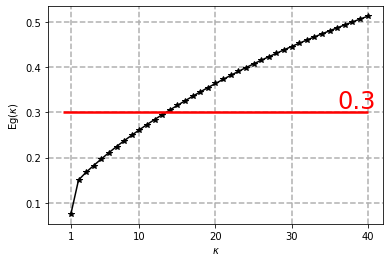

In [6]:
plt.plot(np.arange(1, 41), _[:40] / _[-1], '-*', color = 'k', linewidth = 1.5)
plt.hlines([0.3], xmin = [0.], xmax = [40.], color = "r", linewidth = 2.5)
plt.grid(True, linewidth = 1.5, linestyle = "--")
plt.text(36, 0.31, "0.3", fontsize = 24, color = "r")
plt.ylabel("Eg$(\kappa)$")
plt.xlabel("$\kappa$")
plt.xticks([1, 10, 20, 30, 40])

In [7]:
_[13]/_[-1]

tensor(0.3052)

In [8]:
diff = gt_ten.reshape((-1, 2000)) - pred_ten[..., :2000].reshape((-1, 2000))
mae = torch.linalg.norm(diff, dim = 0)

In [9]:
indices = []

for i1 in range(2000):

    if (mae[i1] == 0):

        indices = indices + [i1]

In [10]:
gt_mat = gt_ten[..., :].reshape((-1, 2000))

mean_flow = gt_mat[..., :2000].mean(dim = -1, keepdim = True)

U, S, VT = torch.linalg.svd(gt_mat - mean_flow, full_matrices = False)

recon = U[:,:49] @ S[:49].diag() @ VT[:49, :]

recon += mean_flow

recon = recon.reshape(gt_ten[..., :2000].shape)

In [11]:
_ = torch.cumsum(S, dim = 0)
_[49]/_[-1]

tensor(0.3062)

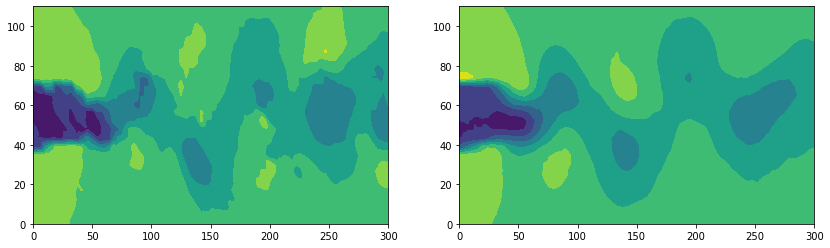

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].contourf(gt_ten[0,:,:,1600].T)
axs[1].contourf(recon[0,:,:,1600].T)

In [13]:
for i1 in indices:

    pred_ten[..., i1] = recon[..., i1]

In [14]:
dx = (65) / recon.shape[1]
dy = (20) / recon.shape[2]

vort_gt = vorticity(recon, dx = 1, dy = 1)
vort_pred = vorticity(pred_ten, dx = 1, dy = 1)

In [15]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 28,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'text.latex.preamble': r'\usepackage{amsmath}'
})

rc('text', usetex=True)

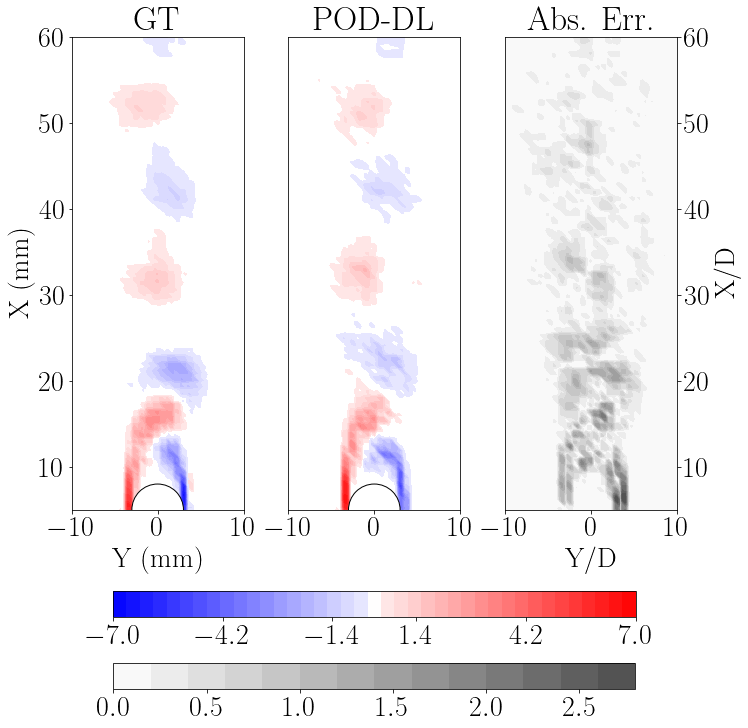

In [16]:
plt.rcParams.update({
    "font.size": 28
})

plt.close("all")

snap = 830

x = np.linspace(5, 60, 301)
y = np.linspace(-10, 10, 111)

fig, axs = plt.subplots(1, 3, figsize = (11, 12))

# vmin = vort_gt[:, :, snap].min()
# vmax = vort_gt[:, :, snap].max()

# vmin = -260
# vmax = 260
vmin = -7.0
vmax = 7.0

levels_1 = np.linspace(0.5, vmax, 20)
levels_2 = np.linspace(vmin, -0.5, 20)
levels = np.concatenate((levels_2, levels_1))

im0 = axs[0].contourf(vort_gt[:, :, snap].T, levels, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[0].clear()
axs[0].contourf(y, x, vort_gt[:, :, snap].T, levels_1, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[0].contourf(y, x, vort_gt[:, :, snap].T, levels_2, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[0].set_title("GT")
axs[0].set_xlabel("Y (mm)")
axs[0].set_ylabel("X (mm)")
circle = plt.Circle((0, 5), 3, facecolor='white', edgecolor='black', zorder=10)
axs[0].add_artist(circle)
axs[0].set_aspect('equal', adjustable='box')

axs[1].contourf(y, x, vort_pred[:, :, snap].T, levels_1, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[1].contourf(y, x, vort_pred[:, :, snap].T, levels_2, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[1].set_title("POD-DL")
axs[1].tick_params(
    left = False, 
    right = False, 
    labelleft = False, 
    labelright = False,
    labelbottom = True, 
    bottom = True
)
circle = plt.Circle((0, 5), 3, facecolor='white', edgecolor='black', zorder=10)
axs[1].add_artist(circle)
axs[1].set_aspect('equal', adjustable='box')

diff = (vort_gt[:, :, snap] - vort_pred[:, :, snap]).abs()
im2 = axs[2].contourf(y, x, diff.T, 15, vmin = 0, vmax = 4, cmap = "gray_r")
axs[2].tick_params(
    left = False, 
    right = True, 
    labelleft = False, 
    labelright = True,
    labelbottom = True, 
    bottom = True
)
axs[2].yaxis.set_label_position('right')
axs[2].set_title("Abs. Err.")
axs[2].set_xlabel("Y/D")
axs[2].set_ylabel("X/D")
axs[2].set_aspect('equal', adjustable='box')

fig.colorbar(im2, ax = axs[0:], fraction = 0.04, ticks = np.linspace(0, 4, 9), pad = 0.07, location = 'bottom')
fig.colorbar(im0, ax = axs[0:], ticks = np.linspace(-7, 7, 6), fraction = 0.045, pad = 0.14, location = 'bottom')

# Metric 1: Quantiles

In [24]:
_ = vort_gt.reshape((-1, 2000))

gt_median = torch.quantile(_, 0.5, dim = 0)
gt_25th = torch.quantile(_, 0.25, dim = 0)
gt_75th = torch.quantile(_, 0.75, dim = 0)

_ = vort_pred[..., :2000].reshape((-1, 2000))

pred_median = torch.quantile(_, 0.5, dim = 0)
pred_25th = torch.quantile(_, 0.25, dim = 0)
pred_75th = torch.quantile(_, 0.75, dim = 0)

del _

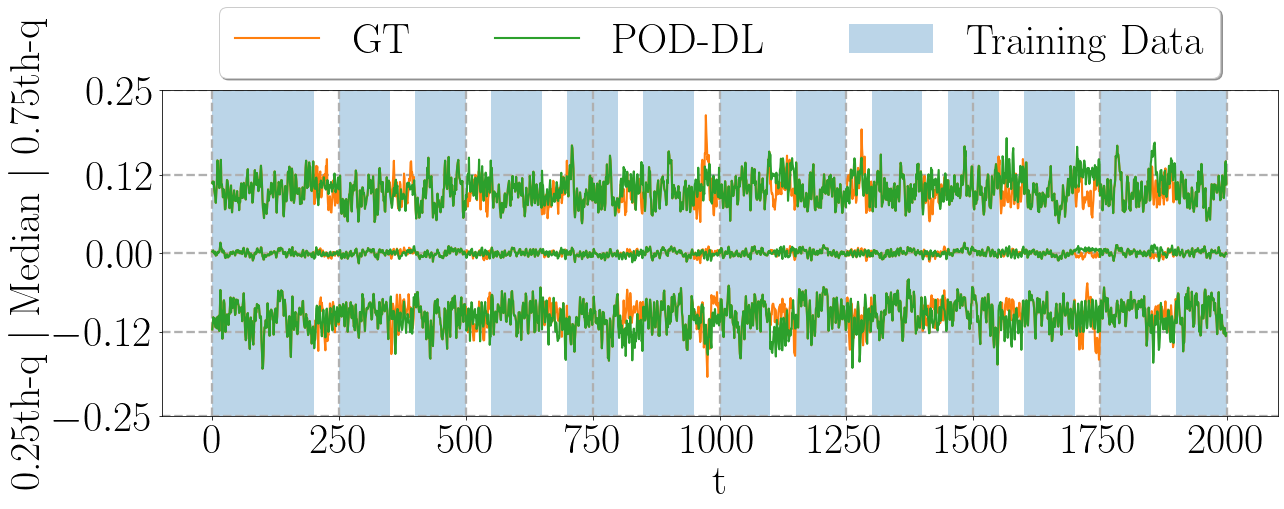

In [26]:
plt.rcParams.update({
    "font.size": 42
})

rc('text', usetex=True)

plt.close('all')
plt.figure(figsize = (20, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(gt_median, c = colors[1], linewidth = 2.1, label = "GT")
plt.plot(pred_median, c = colors[2], linewidth = 2.1, label = "POD-DL")

plt.plot(gt_75th, '-', c = colors[1], linewidth = 2.1)
plt.plot(pred_75th, '-', c = colors[2], linewidth = 2.1)

plt.plot(gt_25th, '-', c = colors[1], linewidth = 2.1)
plt.plot(pred_25th, '-', c = colors[2], linewidth = 2.1)

plt.grid(True, linestyle = '--', linewidth = 2.3)
plt.xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
plt.yticks([-0.25, -0.12, 0.0, 0.12, 0.25])

# # S0=200, S1=200, P=500
# plt.axvspan(0, 200, alpha=0.3, label = "Training Data")
# plt.axvspan(700, 900, alpha=0.3)
# plt.axvspan(1400, 1600, alpha=0.3)

# # S0=200, S1=200, P=100
# plt.axvspan(0, 200, alpha=0.3, label = "Training Data")
# plt.axvspan(300, 500, alpha=0.3)
# plt.axvspan(600, 800, alpha=0.3)
# plt.axvspan(900, 1100, alpha=0.3)
# plt.axvspan(1200, 1400, alpha=0.3)
# plt.axvspan(1500, 1700, alpha=0.3)
# plt.axvspan(1800, 2000, alpha=0.3)

# # S0=200, S1=100, P=100
# plt.axvspan(0, 200, alpha=0.3, label = "Training Data")
# plt.axvspan(300, 400, alpha=0.3)
# plt.axvspan(500, 600, alpha=0.3)
# plt.axvspan(700, 800, alpha=0.3)
# plt.axvspan(900, 1000, alpha=0.3)
# plt.axvspan(1100, 1200, alpha=0.3)
# plt.axvspan(1300, 1400, alpha=0.3)
# plt.axvspan(1500, 1600, alpha=0.3)
# plt.axvspan(1700, 1800, alpha=0.3)
# plt.axvspan(1900, 2000, alpha=0.3)

# S0=200, S1=100, P=50
plt.axvspan(0, 200, alpha=0.3, label = "Training Data")
plt.axvspan(250, 350, alpha=0.3)
plt.axvspan(400, 500, alpha=0.3)
plt.axvspan(550, 650, alpha=0.3)
plt.axvspan(700, 800, alpha=0.3)
plt.axvspan(850, 950, alpha=0.3)
plt.axvspan(1000, 1100, alpha=0.3)
plt.axvspan(1150, 1250, alpha=0.3)
plt.axvspan(1300, 1400, alpha=0.3)
plt.axvspan(1450, 1550, alpha=0.3)
plt.axvspan(1600, 1700, alpha=0.3)
plt.axvspan(1750, 1850, alpha=0.3)
plt.axvspan(1900, 2000, alpha=0.3)

plt.xlabel("t")#, fontsize = 25)
plt.ylabel("0.25th-q $|$ Median $|$ 0.75th-q")#, fontsize = 25)

plt.legend(loc='upper center', bbox_to_anchor = (0.5, 1.32), ncol = 3, fancybox = True, shadow = True)

# Metric 2: TKE

In [17]:
gt_mean_flow = torch.mean(recon, dim = -1, keepdim = True)
pred_mean_flow = torch.mean(pred_ten[..., :recon.shape[-1]], dim = -1, keepdim = True)

gt_fluc = recon - gt_mean_flow
pred_fluc = pred_ten[..., :recon.shape[-1]] - pred_mean_flow

gt_var = torch.trapezoid(gt_fluc**2, dim = -1) / recon.shape[-1]
pred_var = torch.trapezoid(pred_fluc**2, dim = -1) / recon.shape[-1]

gt_tke = 0.5 * (gt_var[0,...] + gt_var[1,...])
pred_tke = 0.5 * (pred_var[0,...] + pred_var[1,...])

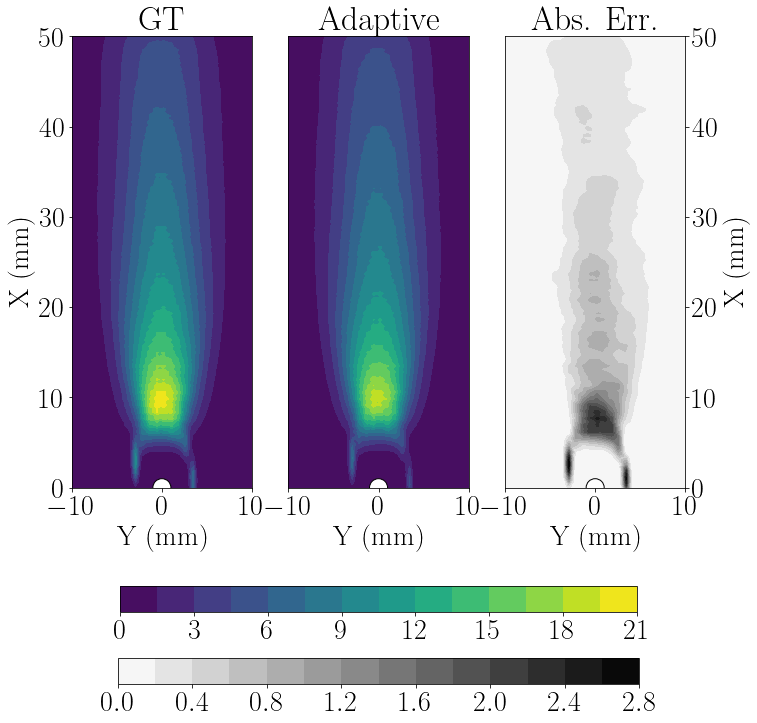

In [19]:
plt.rcParams.update({
    "font.size": 28
})

plt.close('all')

fig, axs = plt.subplots(1, 3, figsize = (11, 12))

vmin = gt_tke.min()
vmax = gt_tke.max()

x = np.linspace(0, 50, gt_tke.shape[0])
y = np.linspace(-10, 10, gt_tke.shape[1])

im1 = axs[0].contourf(y, x, gt_tke, 15, vmin = vmin, vmax = vmax)
axs[0].set_title("GT")
axs[0].set_xlabel("Y (mm)")
axs[0].set_ylabel("X (mm)")
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', zorder=10)
axs[0].add_artist(circle)
axs[0].set_aspect('equal', adjustable='box')

axs[1].contourf(y, x, pred_tke, 15, vmin = vmin, vmax = vmax)
axs[1].set_xlabel("Y (mm)")
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', zorder=10)
axs[1].add_artist(circle)
axs[1].set_aspect('equal', adjustable='box')
axs[1].tick_params(
    left = False, 
    right = False, 
    labelleft = False, 
    labelbottom = True, 
    bottom = True
)
axs[1].set_title("Adaptive")

im2 = axs[2].contourf(y, x, torch.abs(gt_tke - pred_tke), 15, cmap = 'gray_r')
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', zorder=10)
axs[2].set_xlabel("Y (mm)")
axs[2].set_ylabel("X (mm)")
axs[2].yaxis.set_label_position('right')
axs[2].add_artist(circle)
axs[2].set_aspect('equal', adjustable='box')
axs[2].tick_params(
    left = False, 
    right = True, 
    labelleft = False, 
    labelright = True, 
    labelbottom = True, 
    bottom = True
)
axs[2].set_title("Abs. Err.")

plt.colorbar(im2, ax = axs[:], orientation = "horizontal", fraction = 0.04, pad=0.07)
plt.colorbar(im1, ax = axs[:], orientation = "horizontal", fraction = 0.0445, pad = 0.17)

# Metric 3: Jensen-Shannon divergence

In [21]:
def compute_js_divergence(gt_ten, pred_ten):

    vmin = torch.concat((gt_ten.min()[None], pred_ten.min()[None])).max()
    vmax = torch.concat((gt_ten.max()[None], pred_ten.max()[None])).min()

    gt_hist, gt_edges = torch.histogram(
        gt_ten, 
        bins = 5000, 
        density = True
    )
    
    pred_hist, pred_edges = torch.histogram(
        pred_ten, 
        bins = 5000, 
        density = True
    )

    gt_prob = gt_hist * gt_edges.diff()
    pred_prob = pred_hist * pred_edges.diff()

    gt_ten_range = gt_ten[(gt_ten >= vmin) & (gt_ten <= vmax)]

    gt_bin_indices = torch.bucketize(gt_ten_range, gt_edges) - 1
    pred_bin_indices = torch.bucketize(gt_ten_range, pred_edges) - 1

    mean_dist = 0.5 * (gt_prob[gt_bin_indices] + pred_prob[pred_bin_indices])

    kl_div_1 = gt_prob[gt_bin_indices] * torch.log2(
        gt_prob[gt_bin_indices] / mean_dist
    )
    
    kl_div_2 = pred_prob[pred_bin_indices] * torch.log2(
        pred_prob[pred_bin_indices] / mean_dist
    )

    kl_div_1 = kl_div_1.nan_to_num(nan = 0.0)
    kl_div_2 = kl_div_2.nan_to_num(nan = 0.0)

    kl_div_1 = -kl_div_1.sum()
    kl_div_2 = -kl_div_2.sum()

    js_div = 0.5 * (kl_div_1 + kl_div_2)

    return js_div

def jensen_shannon_divergence(vec1, vec2, bins=50):
    """
    Compute the Jensen-Shannon divergence between two vectors of samples.

    Parameters:
        vec1 (np.ndarray): Samples from distribution P.
        vec2 (np.ndarray): Samples from distribution Q.
        bins (int): Number of bins to use for histogram-based density estimation.

    Returns:
        float: The Jensen-Shannon divergence between the distributions.
    """
    # Determine common range for both distributions
    data_min = min(vec1.min(), vec2.min())
    data_max = max(vec1.max(), vec2.max())
    bin_edges = torch.linspace(data_min, data_max, bins + 1)
    
    # Compute histograms; density=True returns a probability density function
    p_hist, _ = torch.histogram(vec1, bins=bin_edges, density=True)
    q_hist, _ = torch.histogram(vec2, bins=bin_edges, density=True)
    
    # Convert density estimates to probabilities by multiplying by bin width
    bin_width = bin_edges[1] - bin_edges[0]
    p = p_hist * bin_width
    q = q_hist * bin_width
    
    # Normalize to ensure the probabilities sum to 1 (just in case)
    p = p / torch.sum(p)
    q = q / torch.sum(q)
    
    # Compute the average distribution M
    m = 0.5 * (p + q)

    # Define a function for KL divergence that handles zeros gracefully.
    def kl_divergence(P, Q):
        # print(P)
        # print(np.where(P != 0, np.log2(P), 0))
        # print("\n")
        # Only compute the term where P is nonzero.
        return torch.sum(torch.where(P != 0, P * (torch.log2(P) -  torch.log2(Q)), 0))
    
    # Compute the JSD as the average of the two KL divergences.
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [22]:
gt_vort_flatten = torch.reshape(vort_gt, (-1, vort_gt.shape[-1]))
pred_vort_flatten = torch.reshape(vort_pred[..., :vort_gt.shape[-1]], (-1, vort_gt.shape[-1]))

js_div = torch.zeros(vort_gt.shape[-1])

for i1 in range(vort_gt.shape[-1]):

    js_div[i1] = jensen_shannon_divergence(
        vort_gt[..., i1].flatten(), 
        vort_pred[..., i1].flatten(),
        bins = 100
    )

In [23]:
torch.linspace(0, 0.05, 5)

tensor([0.0000, 0.0125, 0.0250, 0.0375, 0.0500])

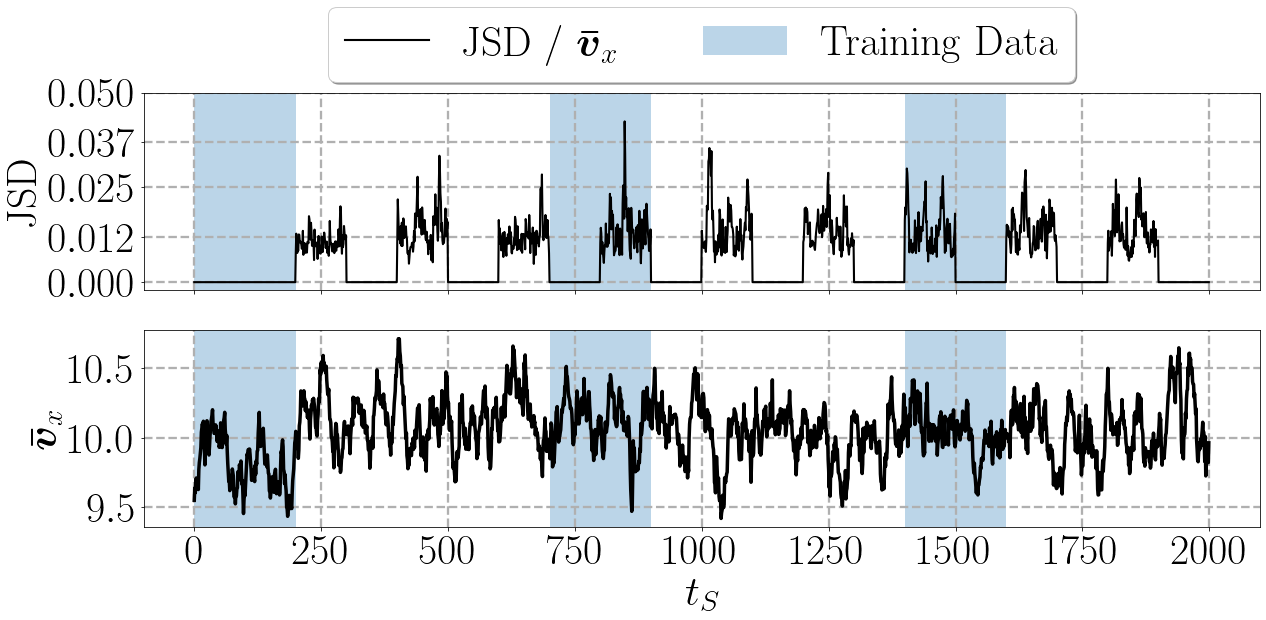

In [24]:
plt.rcParams.update({
    "font.size": 42
})

mean_vor = gt_ten[0,...].mean(dim = (0,1))

plt.close('all')
fig, axs = plt.subplots(2, 1, figsize = (20, 8))

axs[0].plot(js_div, c = 'k', linewidth = 2.1, label = r"JSD / $\boldsymbol{\bar{v}}_{x}$")
axs[0].grid(True, linestyle = '--', linewidth = 2.3)
axs[0].set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
axs[0].set_xticklabels([])
# axs[0].set_yticks([0.0, 0.01, 0.02, 0.03, 0.05])
axs[0].set_yticks([0.0, 0.012, 0.0250, 0.037, 0.05])
axs[0].set_ylabel(r"JSD")

axs[1].plot(mean_vor, "k", linewidth = 3.5)
axs[1].grid(True, linestyle = '--', linewidth = 2.3)
axs[1].set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
axs[1].set_ylabel(r"$\boldsymbol{\bar{v}}_{x}$")
axs[1].set_xlabel(r"$t_{S}$")

# S0=200, S1=200, P=500
axs[0].axvspan(0, 200, alpha=0.3, label = "Training Data")
axs[0].axvspan(700, 900, alpha=0.3)
axs[0].axvspan(1400, 1600, alpha=0.3)
axs[1].axvspan(0, 200, alpha=0.3)
axs[1].axvspan(700, 900, alpha=0.3)
axs[1].axvspan(1400, 1600, alpha=0.3)

# # S0=200, S1=100, P=50
# axs[0].axvspan(0, 200, alpha=0.3, label = "Training Data")
# axs[0].axvspan(250, 350, alpha=0.3)
# axs[0].axvspan(400, 500, alpha=0.3)
# axs[0].axvspan(550, 650, alpha=0.3)
# axs[0].axvspan(700, 800, alpha=0.3)
# axs[0].axvspan(850, 950, alpha=0.3)
# axs[0].axvspan(1000, 1100, alpha=0.3)
# axs[0].axvspan(1150, 1250, alpha=0.3)
# axs[0].axvspan(1300, 1400, alpha=0.3)
# axs[0].axvspan(1450, 1550, alpha=0.3)
# axs[0].axvspan(1600, 1700, alpha=0.3)
# axs[0].axvspan(1750, 1850, alpha=0.3)
# axs[0].axvspan(1900, 2000, alpha=0.3)
# axs[1].axvspan(0, 200, alpha=0.3)
# axs[1].axvspan(250, 350, alpha=0.3)
# axs[1].axvspan(400, 500, alpha=0.3)
# axs[1].axvspan(550, 650, alpha=0.3)
# axs[1].axvspan(700, 800, alpha=0.3)
# axs[1].axvspan(850, 950, alpha=0.3)
# axs[1].axvspan(1000, 1100, alpha=0.3)
# axs[1].axvspan(1150, 1250, alpha=0.3)
# axs[1].axvspan(1300, 1400, alpha=0.3)
# axs[1].axvspan(1450, 1550, alpha=0.3)
# axs[1].axvspan(1600, 1700, alpha=0.3)
# axs[1].axvspan(1750, 1850, alpha=0.3)
# axs[1].axvspan(1900, 2000, alpha=0.3)

axs[0].legend(loc='upper center', bbox_to_anchor = (0.5, 1.54), ncol = 3, fancybox = True, shadow = True)

# Metric 4: Histogram

In [17]:
def compute_hist_mae(err_val, bin_width, gt_ten, pred_ten):

    diff_1 = torch.abs(gt_ten - pred_ten)

    bin_edges_1 = torch.arange(0.0, diff_1.max() + bin_width, bin_width)

    p_hist_1, _ = torch.histogram(diff_1, bins = bin_edges_1, density = True)

    # bin_width = bin_edges[1] - bin_edges[0]

    p_1 = p_hist_1 * bin_width

    # prob_val = torch.where(bin_edges <= err_val)[0][-1]
    prob_val = int(err_val // bin_width)

    return p_1[:prob_val].sum()

In [18]:
diff_p1 = torch.zeros(vort_gt.shape[-1])
diff_p2 = torch.zeros(vort_gt.shape[-1])

for i1 in range(vort_gt.shape[-1]):

    diff_p1[i1] = compute_hist_mae(
        0.2,
        0.05,
        vort_gt[..., i1].flatten(), 
        vort_pred[..., i1].flatten(),
    )

    diff_p2[i1] = compute_hist_mae(
        0.5,
        0.05,
        vort_gt[..., i1].flatten(), 
        vort_pred[..., i1].flatten(),
    )

# diff_p1 = torch.nan_to_num(diff_p1, 1.0)

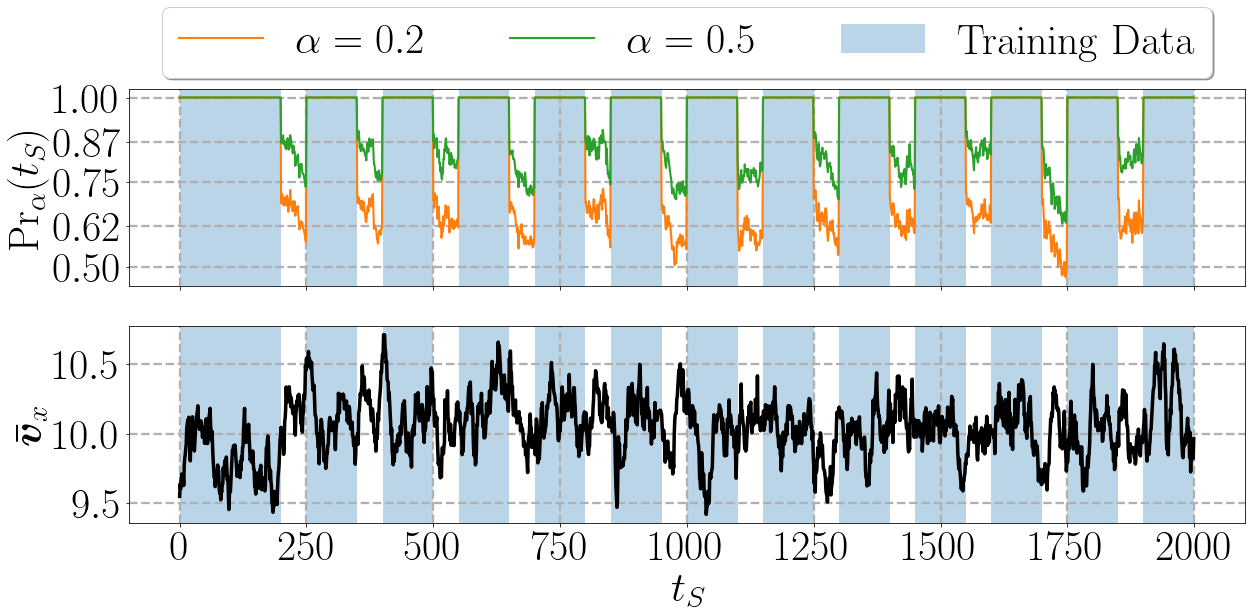

In [20]:
plt.rcParams.update({
    "font.size": 42
})

plt.close('all')

mean_vor = gt_ten[0,...].mean(dim = (0,1))

fig, axs = plt.subplots(2, 1, figsize = (20, 8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(diff_p1, linewidth = 2.1, label = r'$\alpha = 0.2$', c = colors[1])
axs[0].plot(diff_p2, linewidth = 2.1, label = r'$\alpha = 0.5$', c = colors[2])

axs[0].grid(True, linestyle = '--', linewidth = 2.3)
axs[0].set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
# axs[0].set_yticks([0.60, 0.7, 0.7, 0.8, 0.9, 1])
axs[0].set_yticks([0.5, 0.62, 0.75, 0.87, 1])
axs[0].set_xticklabels([])

axs[1].plot(mean_vor, "k", linewidth = 3.5)
axs[1].grid(True, linestyle = '--', linewidth = 2.3)
axs[1].set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
axs[1].set_ylabel(r"$\boldsymbol{\bar{v}}_{x}$")
axs[1].set_xlabel(r"$t_{S}$")

# # # S0=200, S1=200, P=500
# axs[0].axvspan(0, 200, alpha=0.3, label = "Training Data")
# axs[0].axvspan(700, 900, alpha=0.3)
# axs[0].axvspan(1400, 1600, alpha=0.3)
# axs[1].axvspan(0, 200, alpha=0.3)
# axs[1].axvspan(700, 900, alpha=0.3)
# axs[1].axvspan(1400, 1600, alpha=0.3)

# # S0=200, S1=200, P=100
# axs[0].axvspan(0, 200, alpha=0.3, label = "Training Data")
# axs[0].axvspan(300, 500, alpha=0.3)
# axs[0].axvspan(600, 800, alpha=0.3)
# axs[0].axvspan(900, 1100, alpha=0.3)
# axs[0].axvspan(1200, 1400, alpha=0.3)
# axs[0].axvspan(1500, 1700, alpha=0.3)
# axs[0].axvspan(1800, 2000, alpha=0.3)
# axs[1].axvspan(0, 200, alpha=0.3)
# axs[1].axvspan(300, 500, alpha=0.3)
# axs[1].axvspan(600, 800, alpha=0.3)
# axs[1].axvspan(900, 1100, alpha=0.3)
# axs[1].axvspan(1200, 1400, alpha=0.3)
# axs[1].axvspan(1500, 1700, alpha=0.3)
# axs[1].axvspan(1800, 2000, alpha=0.3)

# # S0=200, S1=100, P=100
# axs[0].axvspan(0, 200, alpha=0.3, label = "Training Data")
# axs[0].axvspan(300, 400, alpha=0.3)
# axs[0].axvspan(500, 600, alpha=0.3)
# axs[0].axvspan(700, 800, alpha=0.3)
# axs[0].axvspan(900, 1000, alpha=0.3)
# axs[0].axvspan(1100, 1200, alpha=0.3)
# axs[0].axvspan(1300, 1400, alpha=0.3)
# axs[0].axvspan(1500, 1600, alpha=0.3)
# axs[0].axvspan(1700, 1800, alpha=0.3)
# axs[0].axvspan(1900, 2000, alpha=0.3)
# axs[1].axvspan(0, 200, alpha=0.3)
# axs[1].axvspan(300, 400, alpha=0.3)
# axs[1].axvspan(500, 600, alpha=0.3)
# axs[1].axvspan(700, 800, alpha=0.3)
# axs[1].axvspan(900, 1000, alpha=0.3)
# axs[1].axvspan(1100, 1200, alpha=0.3)
# axs[1].axvspan(1300, 1400, alpha=0.3)
# axs[1].axvspan(1500, 1600, alpha=0.3)
# axs[1].axvspan(1700, 1800, alpha=0.3)
# axs[1].axvspan(1900, 2000, alpha=0.3)

# S0=200, S1=100, P=50
axs[0].axvspan(0, 200, alpha=0.3, label = "Training Data")
axs[0].axvspan(250, 350, alpha=0.3)
axs[0].axvspan(400, 500, alpha=0.3)
axs[0].axvspan(550, 650, alpha=0.3)
axs[0].axvspan(700, 800, alpha=0.3)
axs[0].axvspan(850, 950, alpha=0.3)
axs[0].axvspan(1000, 1100, alpha=0.3)
axs[0].axvspan(1150, 1250, alpha=0.3)
axs[0].axvspan(1300, 1400, alpha=0.3)
axs[0].axvspan(1450, 1550, alpha=0.3)
axs[0].axvspan(1600, 1700, alpha=0.3)
axs[0].axvspan(1750, 1850, alpha=0.3)
axs[0].axvspan(1900, 2000, alpha=0.3)
axs[1].axvspan(0, 200, alpha=0.3)
axs[1].axvspan(250, 350, alpha=0.3)
axs[1].axvspan(400, 500, alpha=0.3)
axs[1].axvspan(550, 650, alpha=0.3)
axs[1].axvspan(700, 800, alpha=0.3)
axs[1].axvspan(850, 950, alpha=0.3)
axs[1].axvspan(1000, 1100, alpha=0.3)
axs[1].axvspan(1150, 1250, alpha=0.3)
axs[1].axvspan(1300, 1400, alpha=0.3)
axs[1].axvspan(1450, 1550, alpha=0.3)
axs[1].axvspan(1600, 1700, alpha=0.3)
axs[1].axvspan(1750, 1850, alpha=0.3)
axs[1].axvspan(1900, 2000, alpha=0.3)

axs[1].set_xlabel(r"$t_{S}$")
axs[0].set_ylabel(r"$\text{Pr}_{\alpha}(t_{S})$")

axs[0].legend(loc='upper center', bbox_to_anchor = (0.5, 1.52), ncol = 4, fancybox = True, shadow = True)